# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


%matplotlib inline

# Loading the Data

In [ ]:
data = pd.read_csv('/content/TeleCom_Data-2.csv', header=None)

# Since the dataset appears to be being read as a single column and wrapped in quotation marks-- as found in assignment 1
# Manually split the single column into multiple columns
data = data[0].str.split(';', expand=True)

# Setting the first row as the header
data.columns = data.iloc[0]
data = data[1:]

data.columns = data.columns.str.replace('"', '').str.strip()

for column in data.columns:
    data[column] = data[column].str.replace('"', '').str.strip()

print(data.head())

0 age          job  marital            education  default housing loan  \
1  40       admin.  married             basic.6y       no      no   no   
2  56     services  married          high.school       no      no  yes   
3  45     services  married             basic.9y  unknown      no   no   
4  59       admin.  married  professional.course       no      no   no   
5  41  blue-collar  married              unknown  unknown      no   no   

0    contact month day_of_week  ... campaign pdays previous     poutcome  \
1  telephone   may         mon  ...        1   999        0  nonexistent   
2  telephone   may         mon  ...        1   999        0  nonexistent   
3  telephone   may         mon  ...        1   999        0  nonexistent   
4  telephone   may         mon  ...        1   999        0  nonexistent   
5  telephone   may         mon  ...        1   999        0  nonexistent   

0 emp.var.rate cons.price.idx cons.conf.idx euribor3m nr.employed   y  
1          1.1         93.

* The data values were also wrapped with extra double quotes("").
* The data types for all the columns are Object type.

### Define the correct data types for each column

In [ ]:
data = data.astype({
    'age': 'int64',
    'job': 'object',
    'marital': 'object',
    'education': 'object',
    'default': 'object',
    'housing': 'object',
    'loan': 'object',
    'contact': 'object',
    'month': 'object',
    'day_of_week': 'object',
    'duration': 'int64',
    'campaign': 'int64',
    'pdays': 'int64',
    'previous': 'int64',
    'poutcome': 'object',
    'emp.var.rate': 'float64',
    'cons.price.idx': 'float64',
    'cons.conf.idx': 'float64',
    'euribor3m': 'float64',
    'nr.employed': 'float64',
    'y': 'object'
})

print(data.dtypes)

0
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


*As found in assignment 1, columns, e.g., job, marital, education, default, housing, and loan, have "unknown" as a possible value, which could indicate incomplete information. However, the prevalence of unknown values across various categorical fields has an insignificant impact on the target variable. Hence, keeping these values as they are.*

# Data Preprocessing

### Dealing with any duplicated rows -- expanding Assignment 1

In [ ]:
print(f"Number of duplicate rows: {data.duplicated().sum()}")

data = data.drop_duplicates()

print(f"Number of duplicate rows after removal: {data.duplicated().sum()}")

Number of duplicate rows: 12
Number of duplicate rows after removal: 0


### Target Variable Transformation

In [ ]:
# Convert the target variable 'y' to binary (1 for 'yes', 0 for 'no')
data['y'] = data['y'].map({'yes': 1, 'no': 0})

### Handling Outliers

In [ ]:
# function to cap outliers based on interquartile range (IQR)
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [ ]:
# Apply the outlier cap to numerical columns with skewed distributions found from Assignment 1
for column in ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
    cap_outliers(data, column)

In [ ]:
# List of categorical columns for one hot encoding
categorical_columns = [col for col in data.columns if data.dtypes[col] == 'object']

# List of numerical columns to standardized data
numerical_columns = [col for col in data.columns if (data.dtypes[col] != 'object' and col != 'y')]

print('Categorical Features are : ',categorical_columns)
print('Numerical Features are : ',numerical_columns)

Categorical Features are :  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical Features are :  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Encoding Categorical Variables

In [ ]:
# Label encode binary columns
binary_columns = ['default', 'housing', 'loan']
for column in binary_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# One-hot encoding for remaining categorical variables
data = pd.get_dummies(data, drop_first=True)

### Standardization on Numerical Features

In [ ]:
scaler = StandardScaler()
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### Feature Selection

In [ ]:
X = data.drop(columns='y')
y = data['y']

In [ ]:
# VarianceThreshold with threshold=0 will remove constant columns
constant_filter = VarianceThreshold(threshold=0)
X_filtered = constant_filter.fit_transform(X)
X_filtered_columns = X.columns[constant_filter.get_support()]

X = pd.DataFrame(X_filtered, columns=X_filtered_columns)

### Select top features using ANOVA F-test

In [ ]:
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Selected Features:", selected_features)

Selected Features: Index(['default', 'duration', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
       'nr.employed', 'job_retired', 'job_student', 'contact_telephone',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


# Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Model Development

## Model 1: Logistic Regression (Parametric with MLE)

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

### Cross-validation for Logistic Regression

In [ ]:
log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')

## Model Evaluation - Logistic Regression

In [ ]:
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_precision = precision_score(y_test, y_pred_log_reg)
log_reg_recall = recall_score(y_test, y_pred_log_reg)
log_reg_f1 = f1_score(y_test, y_pred_log_reg)
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

In [ ]:
print("Logistic Regression Metrics:")
print(f"Accuracy: {log_reg_accuracy:.2f}, Precision: {log_reg_precision:.2f}, Recall: {log_reg_recall:.2f}, F1-Score: {log_reg_f1:.2f}, ROC-AUC: {log_reg_roc_auc:.2f}")

Logistic Regression Metrics:
Accuracy: 0.91, Precision: 0.67, Recall: 0.42, F1-Score: 0.52, ROC-AUC: 0.94


### Confusion Matrix for Logistic Regression Model

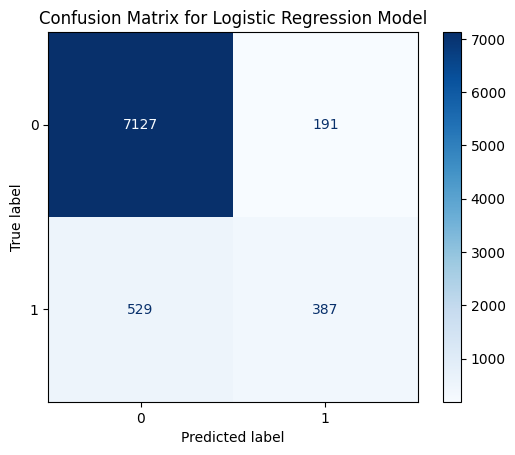

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

### Precision-Recall Curve for Logistic Regression Model

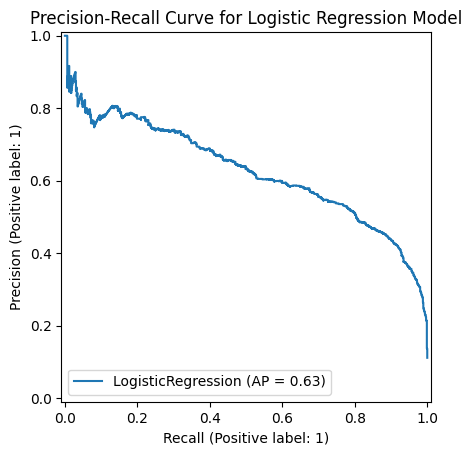

In [ ]:
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("Precision-Recall Curve for Logistic Regression Model")
plt.show()

### Feature Analysis (Logistic Regression Model)

In [ ]:
# Coefficients for the features
coefficients = log_reg.coef_[0]

feature_importance_log_reg = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

feature_importance_log_reg['Abs_Coefficient'] = np.abs(feature_importance_log_reg['Coefficient'])

feature_importance_log_reg = feature_importance_log_reg.sort_values(by='Abs_Coefficient', ascending=False)

print("Top 10 Important Features for Logistic Regression:")
print(feature_importance_log_reg.head(10))

Top 10 Important Features for Logistic Regression:
                 Feature  Coefficient  Abs_Coefficient
14      poutcome_success     1.979558         1.979558
9              month_mar     1.688308         1.688308
1               duration     1.424737         1.424737
2           emp.var.rate    -1.281217         1.281217
4              euribor3m     0.967883         0.967883
10             month_may    -0.903019         0.903019
5            nr.employed    -0.889020         0.889020
7            job_student     0.451043         0.451043
13  poutcome_nonexistent     0.442122         0.442122
6            job_retired     0.412993         0.412993


### Top 10 most important features with Logistic Regression

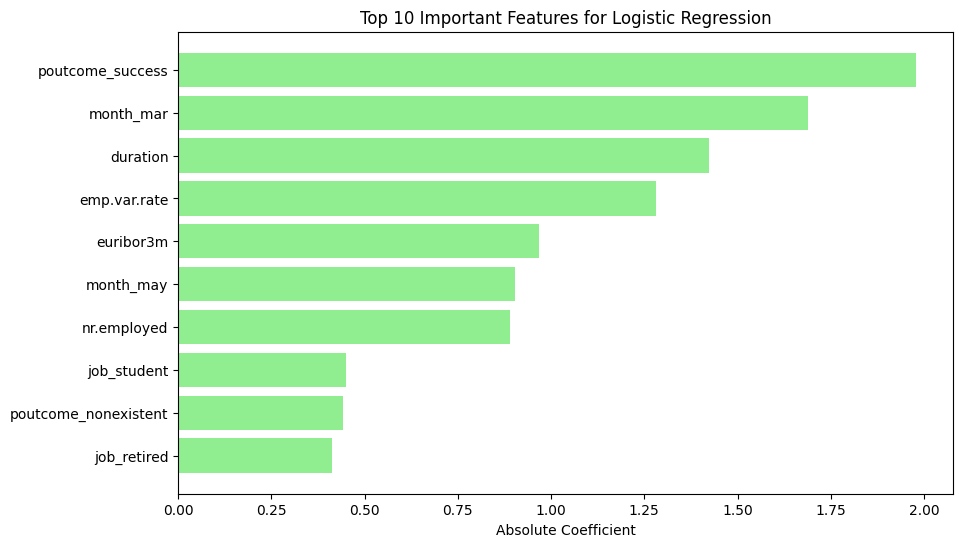

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_log_reg['Feature'].head(10), feature_importance_log_reg['Abs_Coefficient'].head(10), color='lightgreen')
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Important Features for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

### Bar Plot of Evaluation Metrics -- Logistic Regression

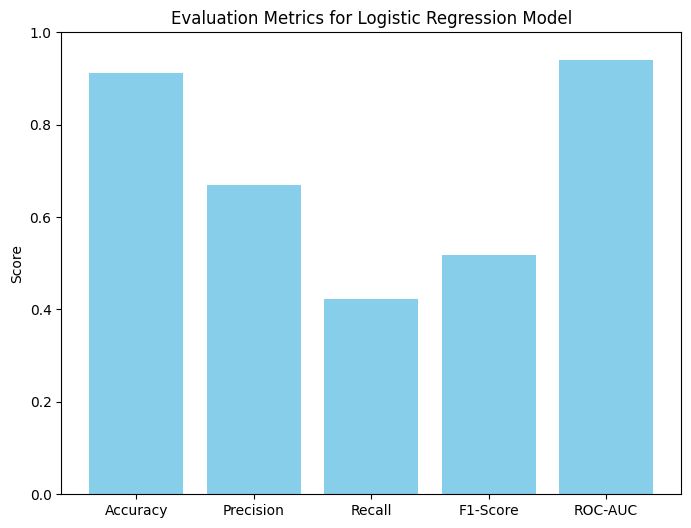

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1, log_reg_roc_auc]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title("Evaluation Metrics for Logistic Regression Model")
plt.ylabel("Score")
plt.show()

## Model 2: Decision Tree (Non-Parametric)

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

### Cross-validation for Decision Tree

In [ ]:
tree_cv_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc')

## Model Evaluation - Decision Tree

In [ ]:
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_precision = precision_score(y_test, y_pred_tree)
tree_recall = recall_score(y_test, y_pred_tree)
tree_f1 = f1_score(y_test, y_pred_tree)
tree_roc_auc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

In [ ]:
print("\nDecision Tree Metrics:")
print(f"Accuracy: {tree_accuracy:.2f}, Precision: {tree_precision:.2f}, Recall: {tree_recall:.2f}, F1-Score: {tree_f1:.2f}, ROC-AUC: {tree_roc_auc:.2f}")


Decision Tree Metrics:
Accuracy: 0.91, Precision: 0.67, Recall: 0.45, F1-Score: 0.54, ROC-AUC: 0.91


### Confusion Matrix for Decision Tree Model

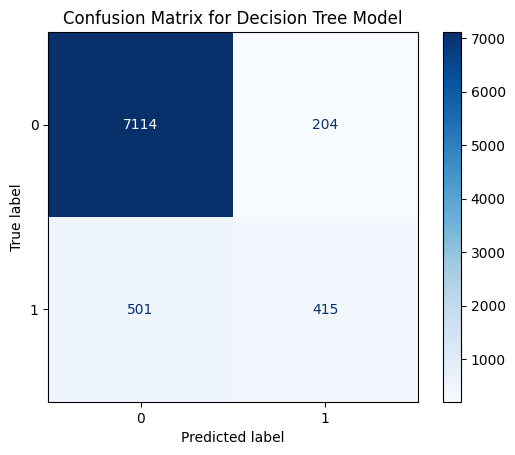

In [ ]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

### Precision-Recall Curve for Decision Tree Model

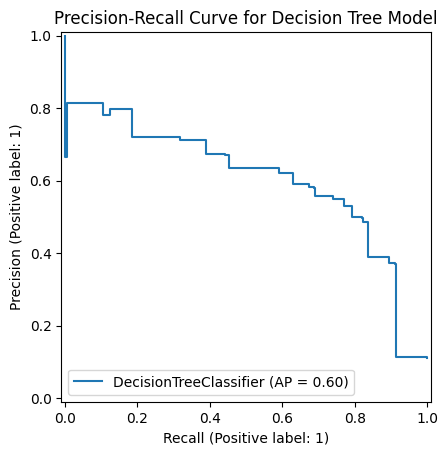

In [ ]:
PrecisionRecallDisplay.from_estimator(tree, X_test, y_test)
plt.title("Precision-Recall Curve for Decision Tree Model")
plt.show()

### Feature Analysis (Decision Tree Model)

In [ ]:
importances = tree.feature_importances_

feature_importance_tree = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

feature_importance_tree = feature_importance_tree.sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for Decision Tree:")
print(feature_importance_tree.head(10))

Top 10 Important Features for Decision Tree:
              Feature  Importance
1            duration    0.510432
5         nr.employed    0.372369
14   poutcome_success    0.040456
9           month_mar    0.028336
4           euribor3m    0.016742
11          month_oct    0.016189
3      cons.price.idx    0.007584
8   contact_telephone    0.005960
0             default    0.001931
2        emp.var.rate    0.000000


### Top 10 most important features with Decision Tree

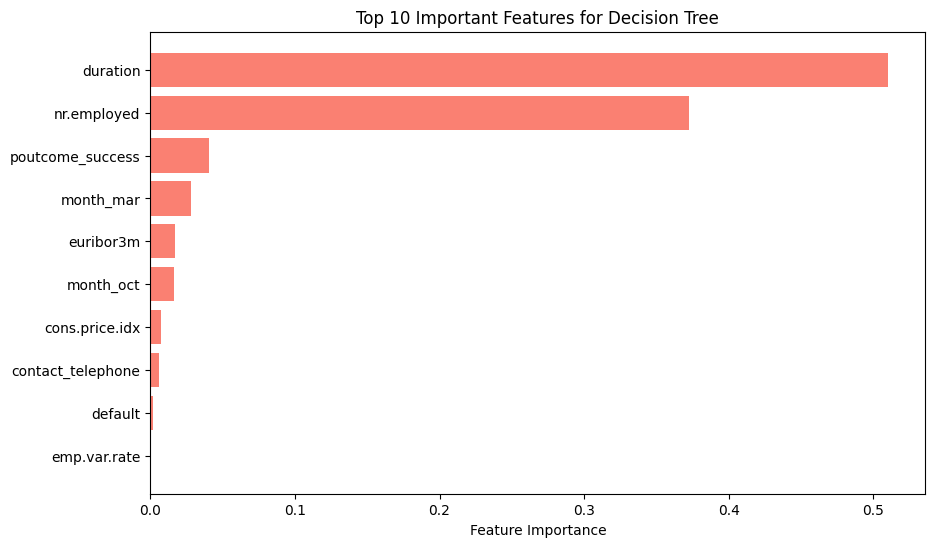

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_tree['Feature'].head(10), feature_importance_tree['Importance'].head(10), color='salmon')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Decision Tree')
plt.gca().invert_yaxis()
plt.show()

### Bar Plot of Evaluation Metrics -- Decision Tree

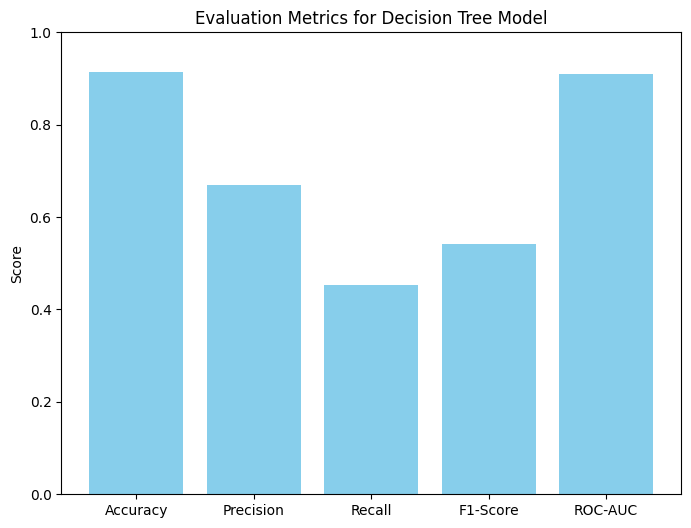

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [tree_accuracy, tree_precision, tree_recall, tree_f1, tree_roc_auc]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title("Evaluation Metrics for Decision Tree Model")
plt.ylabel("Score")
plt.show()

# Model Comparison and ROC Curves

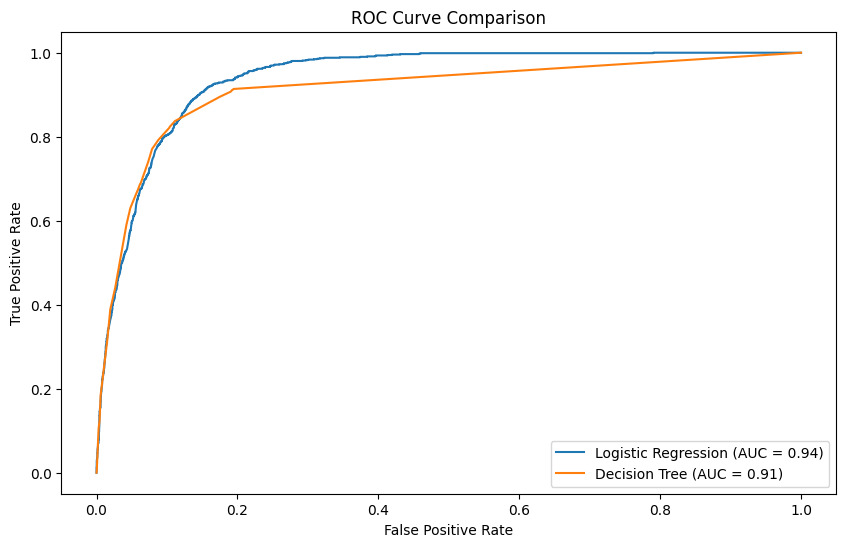

In [ ]:
plt.figure(figsize=(10, 6))
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_roc_auc:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {tree_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Grouped Bar Chart for Performance Comparison of the two models

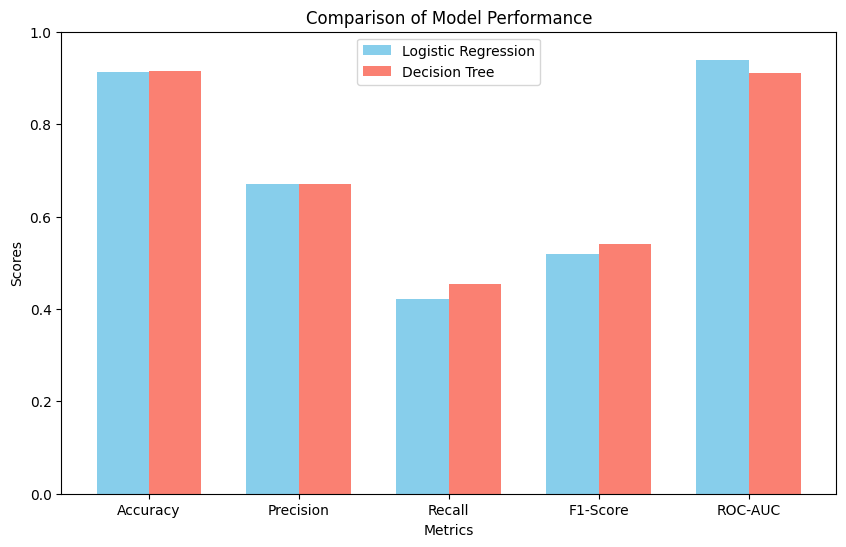

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
model_1_values = [log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1, log_reg_roc_auc]
model_2_values = [tree_accuracy, tree_precision, tree_recall, tree_f1, tree_roc_auc]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, model_1_values, width, label='Logistic Regression', color='skyblue')
bars2 = ax.bar(x + width/2, model_2_values, width, label='Decision Tree', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

plt.show()

### Cross-validation and Comparative Analysis

In [ ]:
print("\nCross-Validation AUC Scores:")
print(f"Logistic Regression CV AUC: {log_reg_cv_scores.mean():.2f} ± {log_reg_cv_scores.std():.2f}")
print(f"Decision Tree CV AUC: {tree_cv_scores.mean():.2f} ± {tree_cv_scores.std():.2f}")


Cross-Validation AUC Scores:
Logistic Regression CV AUC: 0.93 ± 0.00
Decision Tree CV AUC: 0.90 ± 0.01
